In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [4]:
import cupy as cp

In [5]:
PROJECT_PATH = '../'
BLUE_PATH = "/scratch/ceph/szalay/swei20/AE/norm_flux_Blue_R2300.h5"
NIR_PATH = "/scratch/ceph/szalay/swei20/AE/norm_flux_NIR_R4300.h5"
sys.path.insert(0, PROJECT_PATH)

# Red Arm

In [110]:
from lv.base.basePCA import PCA

In [111]:
p=PCA()
p.W = p.Ws["RedM"]

In [112]:
PATH = f"/scratch/ceph/szalay/swei20/AE/norm_flux_{p.W[3]}_R{p.W[2]}.h5"

with h5py.File(PATH, 'r') as f:
    flux0 = f['flux'][()]
    wave0 = f['wave'][()]
    para0 = f['para'][()]

In [113]:
flux0.shape

(116614, 2204)

In [114]:
p.prepare_data(flux0, wave0, para0)


# M flux: 7689, wave None: (2204,) 
# W flux: 6480, wave None: (2204,) 
# C flux: 3780, wave None: (2204,) 
# B flux: 3300, wave None: (2204,) 
# R flux: 2100, wave None: (2204,) 
# G flux: 9972, wave None: (2204,) 


In [115]:
fluxs = []
lbls = []
paras = []
for ii, (key, flux) in enumerate(p.nFlux.items()):
    if key != "G":
        para = p.nPara[key]
        n = len(flux)
        fluxs.append(flux)
        paras.append(para)
        lbls.append(np.zeros(n) + ii)
fluxs = np.vstack(fluxs)
paras = np.vstack(paras)
lbls = np.hstack(lbls)

In [116]:
paras.shape

(23349, 5)

In [117]:
lbls.shape

(23349,)

In [118]:
fluxs.shape

(23349, 2204)

In [119]:
PATH = f"/scratch/ceph/swei20/data/dnn/ALL/norm_flux.h5"

In [120]:
with h5py.File(PATH, 'a') as f:
#     f.create_dataset("fluxR", data=fluxs, shape=fluxs.shape)
    f.create_dataset("lblR", data=lbls, shape=lbls.shape)
    f.create_dataset("paraR", data=paras, shape=paras.shape)




In [121]:
from lv.base.dataloader_c import DataLoader

In [122]:
ds = DataLoader()

In [127]:
ds.prepare_data_custom("RedM", fluxs, wave0, paras, lbl=lbls)

(23349, 2204) (2204,) (23349, 5)


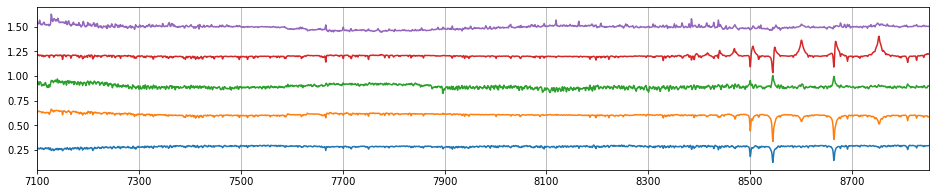

In [128]:
ds.init_pcp()

In [131]:
k,q,prom = 10, 0.75, 0.02
# k,q,prom = 5, 0.7,0.02
peaks, prop, nvv= ds.get_peaks(k=k,q=q,prom=prom)

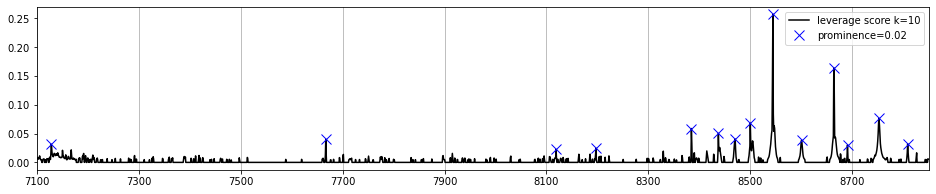

In [132]:
ds.plot_peaks(nvv, peaks, k, prom)

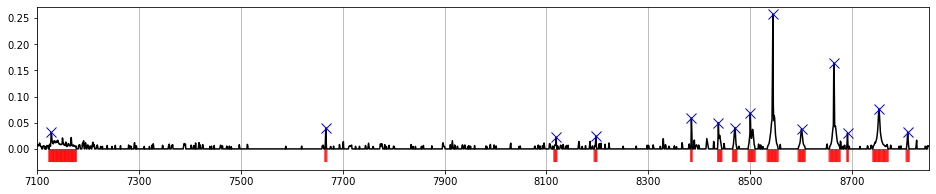

In [133]:
ds.plot_mask_from_peaks(peaks, prop, nvv)

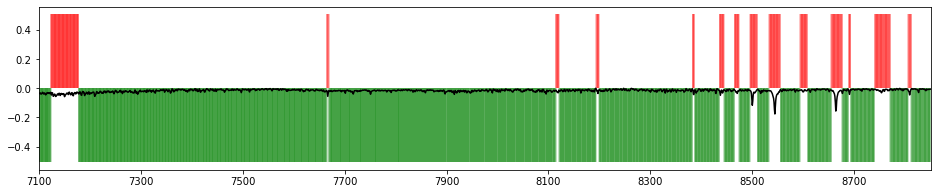

In [134]:
ds.plot_MN_mask(0)

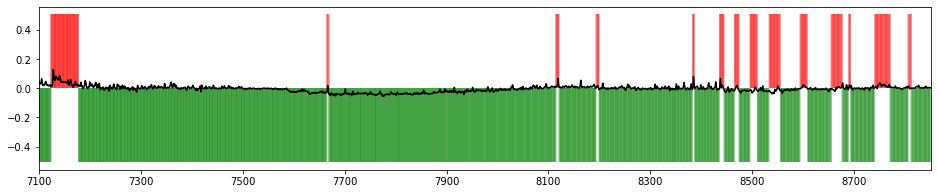

In [135]:
ds.plot_MN_mask(4)

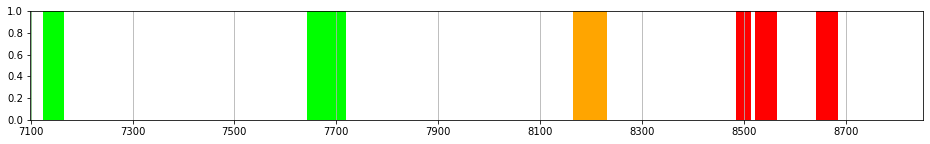

In [136]:
ds.plot_lick()

In [137]:
ds.get_MN(ds.nmask, top=5)

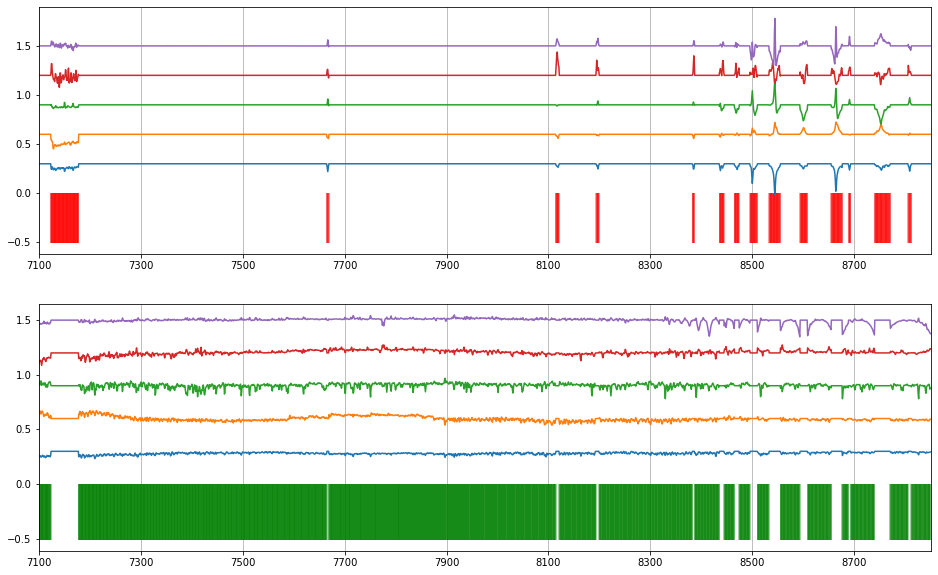

In [138]:
ds.plot_MN(step=0.3)

In [139]:
mu = 1.0 / ds.Mw[2]
ML, MS, MLv, MSv = ds._pcp(ds.M, delta=1e-5, mu=mu, lam=None, norm=None, maxiter=1000)

mu 0.01, lambda 0.0065, norm 165279.1


L(49, 255), S(30, 255)


(49, 2204)


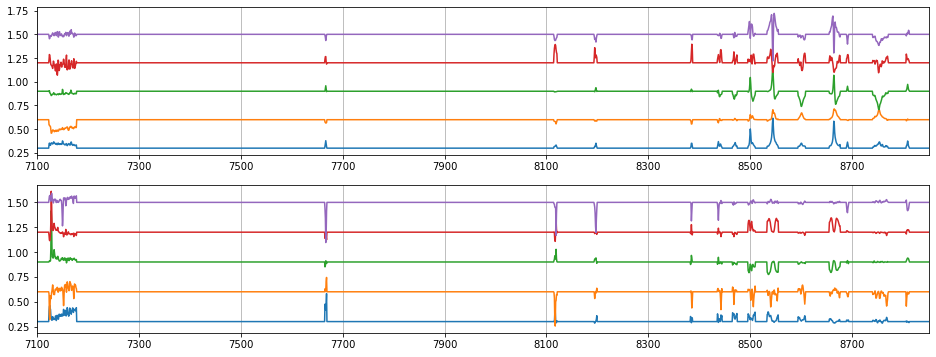

In [140]:
nMLv, nMSv =ds.eval_pcp(MLv, MSv)

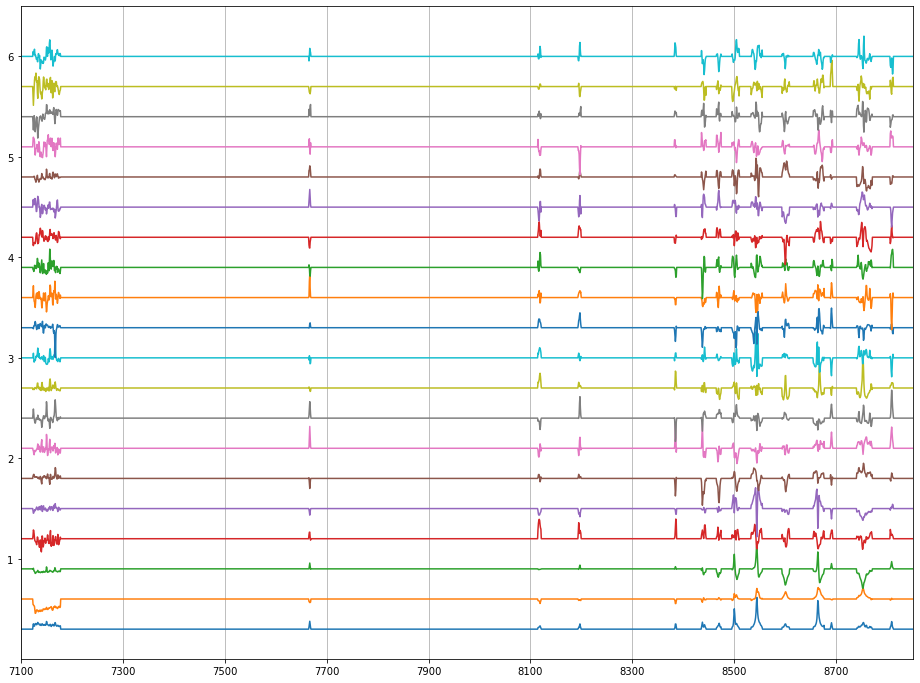

In [141]:
ds.plot_V(nMLv, top=20)

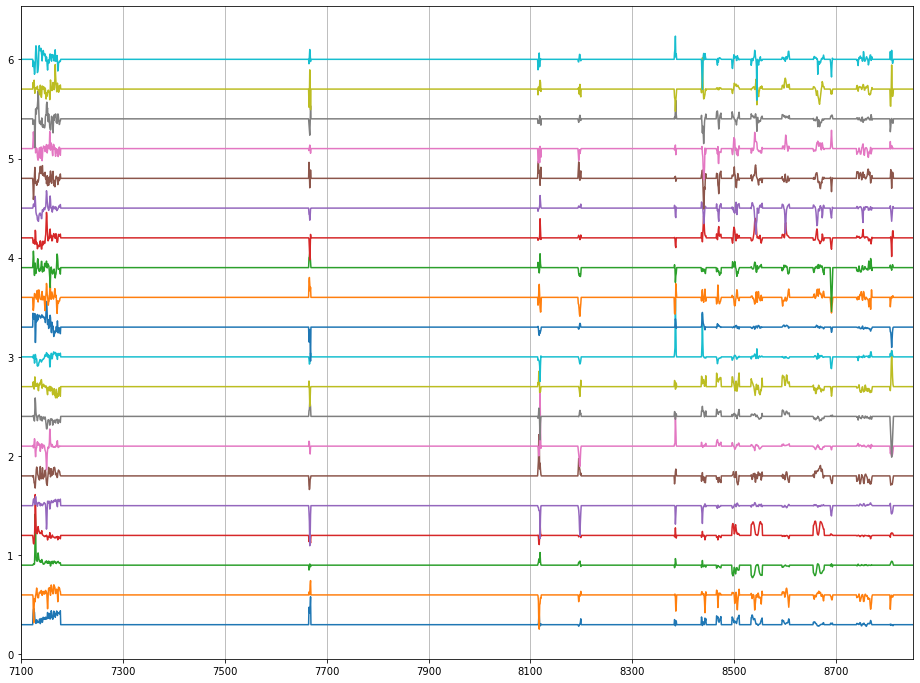

In [142]:
ds.plot_V(nMSv, top=20)

In [143]:
mu = 1.0 / ds.Nw[2]
NL, NS, NLv, NSv = ds._pcp(ds.N, delta=1e-6, mu=mu, lam=None, norm=None, maxiter=100)

mu 0.01, lambda 0.0065, norm 192254.9


L(45, 1949), S(30, 1949)


(45, 2204)


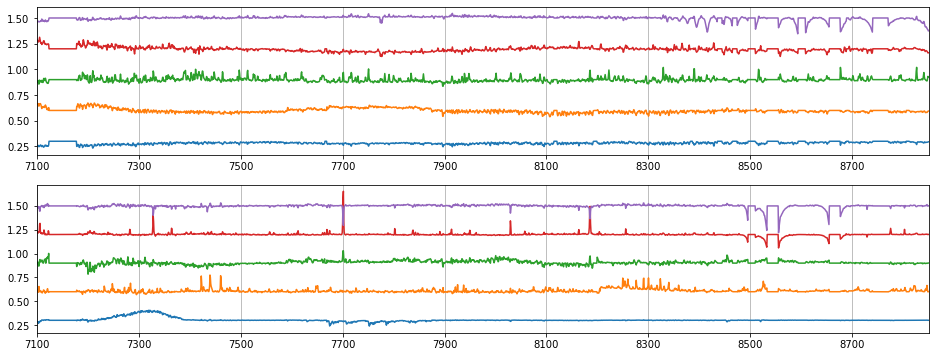

In [144]:
nNLv, nNSv = ds.eval_pcp(NLv, NSv, isM=0)

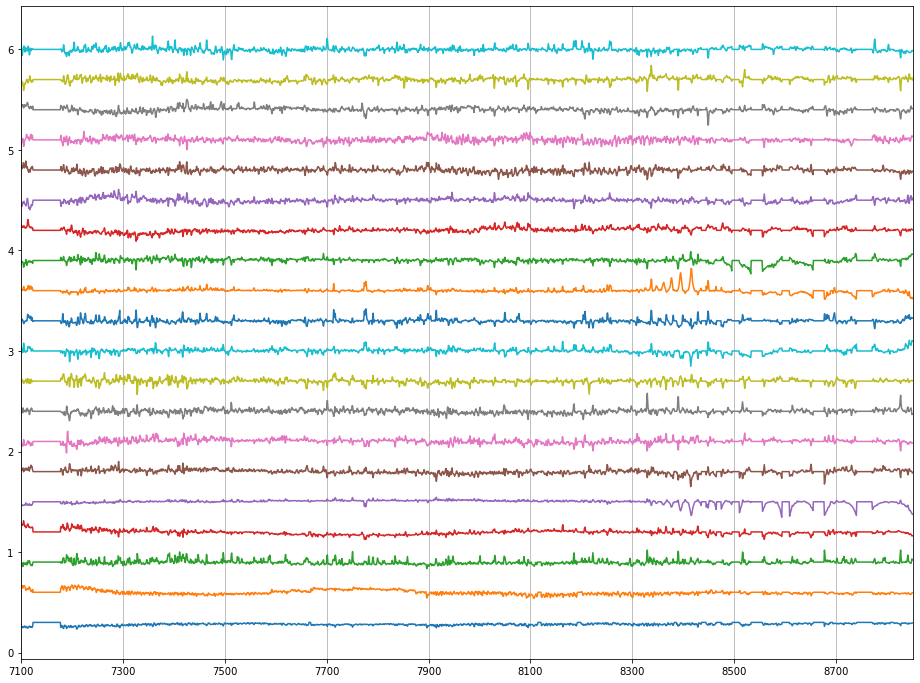

In [145]:
ds.plot_V(nNLv, top=20)

In [146]:
ds.pcp_transform(MLv, MSv, NLv, NSv, top=20)

In [149]:
ds.pcp_np(save=1)

/scratch/ceph/swei20/data/dnn/ALL/bosz_pcp.h5


# Get informative lines

In [304]:
ds.prepare_lines()

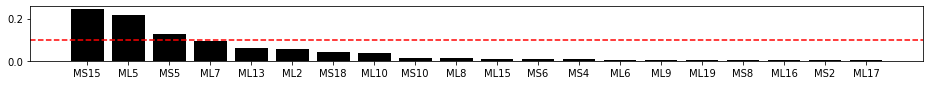

In [300]:
ds.get_X_cluster(X="M")

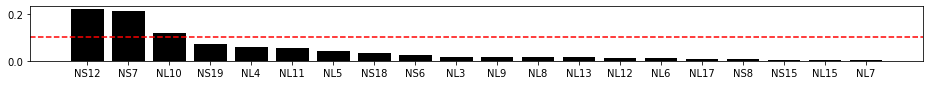

In [301]:
ds.get_X_cluster(X="N")

In [331]:
ds.Cdx["M"].shape

(40,)

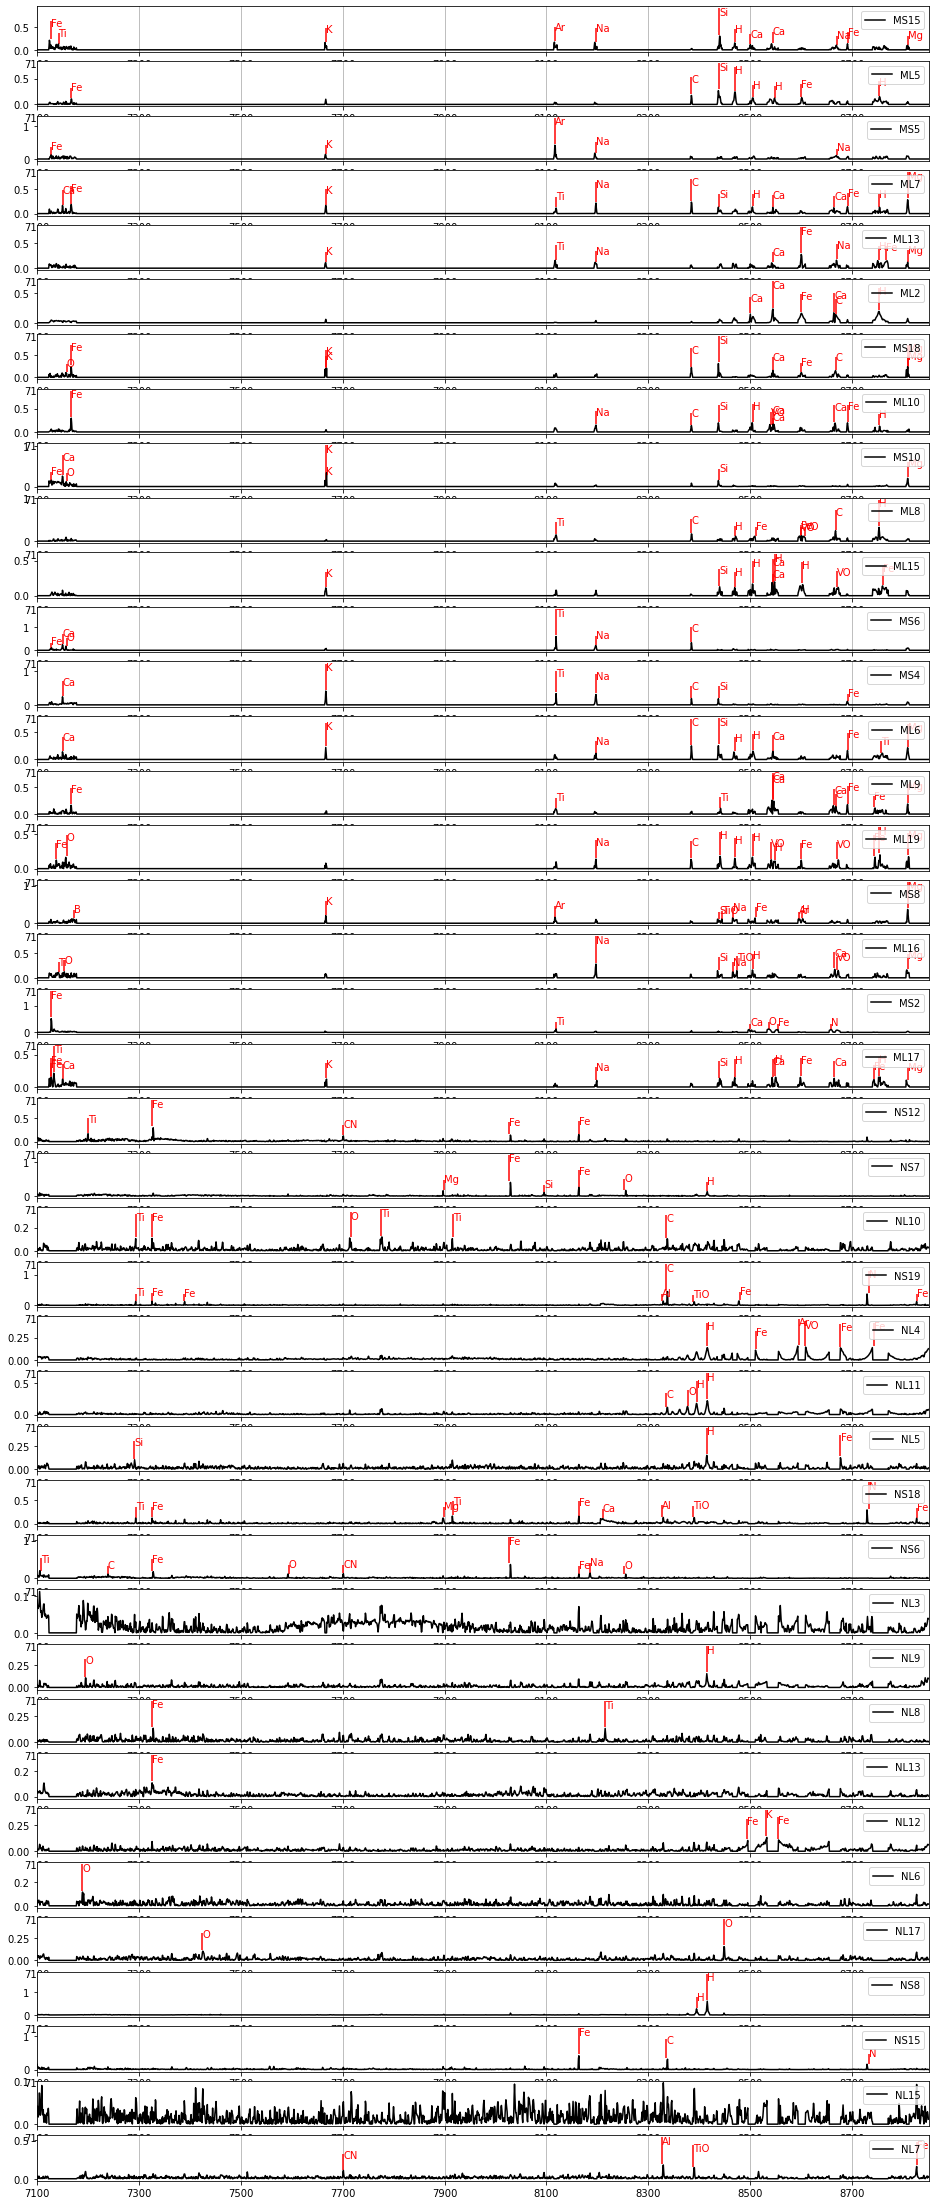

In [332]:
ds.plot_XdxAll(top=20, rfr=0)

In [333]:
ds.CdxAll

array([35,  5, 25,  7, 13,  2, 38, 10, 30,  8, 15, 26, 24,  6,  9, 19, 28,
       16, 22, 17, 72, 67, 50, 79, 44, 51, 45, 78, 66, 43, 49, 48, 53, 52,
       46, 57, 68, 75, 55, 47])

In [334]:
nFluxC = ds.npcpFlux[:, ds.CdxAll]

In [335]:
nFluxC.shape

(23349, 40)

In [315]:
from cuml import UMAP

In [316]:
umap_dim = 5
u = UMAP(n_neighbors=500, n_components=umap_dim)

In [317]:
uu = u.fit_transform(Flux16)

In [318]:
nuu = cp.asnumpy(uu)

In [319]:
dfumap = pd.DataFrame(data=nuu, columns = [f"u{i}" for i in range(umap_dim)])

In [327]:
lbln = [RRs[int(ds.lbl[i])] for i in range(len(ds.lbl))]

In [328]:
dfumap["lbl"]=lbln

In [329]:
dfumap["lbl"].unique()

array(['M31G', 'MWW', 'MWC', 'BHB', 'RHB'], dtype=object)

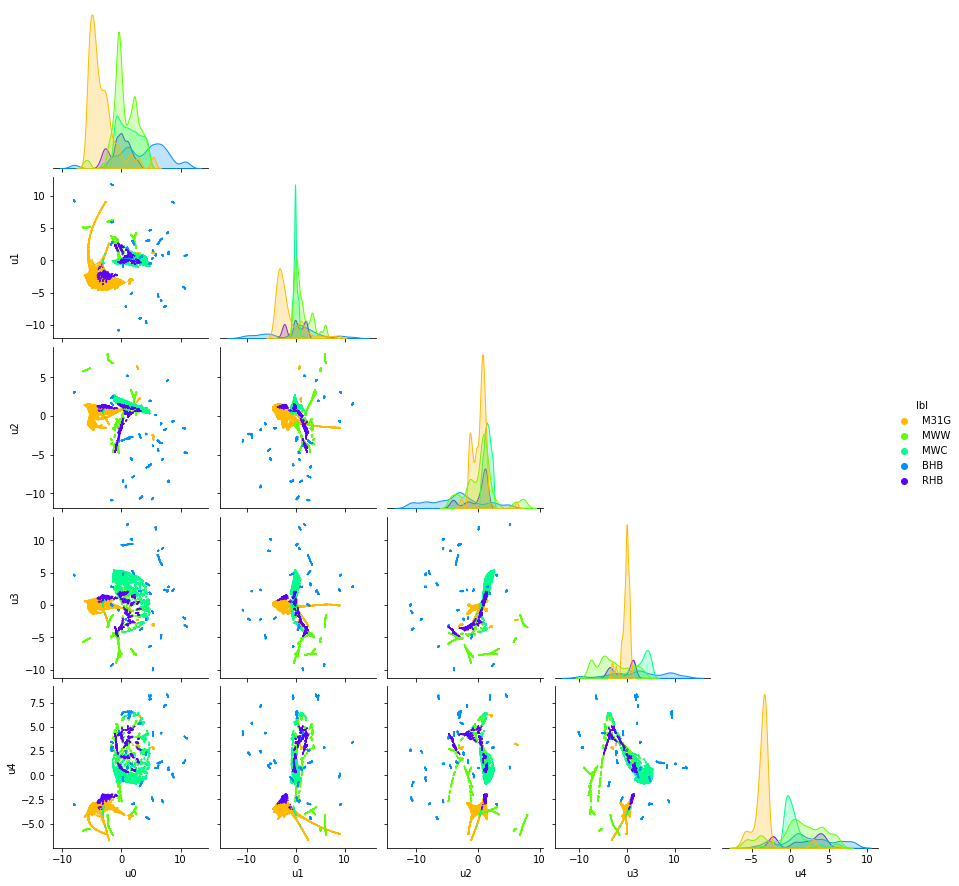

In [330]:
sns.pairplot(
    dfumap,
    x_vars = [f"u{i}" for i in range(umap_dim)],
    y_vars = [f"u{i}" for i in range(umap_dim)],
    hue = "lbl",
    plot_kws=dict(marker="o", s=2, edgecolor="none"),
    diag_kws=None,
    palette="gist_rainbow",
    corner=True
)

<AxesSubplot:xlabel='u0', ylabel='u4'>

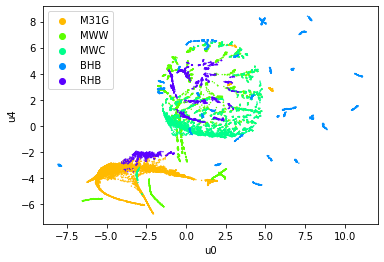

In [338]:
sns.scatterplot(data=dfumap, x="u0",y="u4", hue=lbln,marker="o", s=2, edgecolor="none", palette="gist_rainbow" )

In [291]:
for i in range(cutoff*2):
    ds.dfpara[f"C{i}"] = nFluxC[:, i]

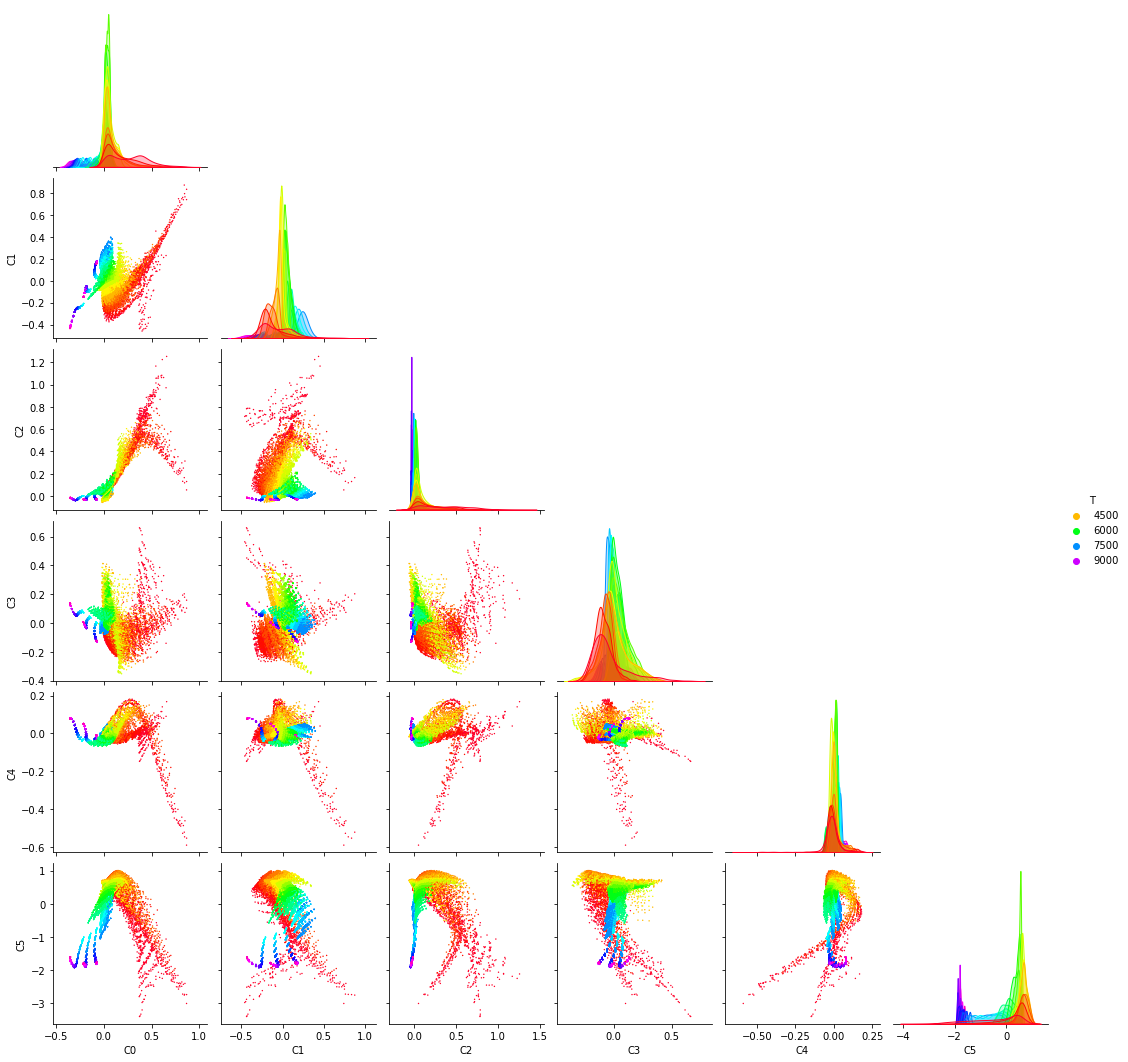

In [293]:
sns.pairplot(
    ds.dfpara,
    x_vars = [f"C{i}" for i in range(cutoff)],
    y_vars = [f"C{i}" for i in range(cutoff)],
    hue = "T",
    plot_kws=dict(marker="o", s=2, edgecolor="none"),
    diag_kws=None,
    palette="gist_rainbow",
    corner=True
)

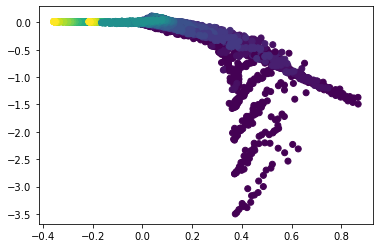

In [290]:
plt.scatter(nFluxC[:,0], nFluxC[:,cutoff + 0], c=ds.dfpara["T"].values)

In [ ]:
ds.dfpara

In [260]:
ds.dfpara

,F,T,L,C,O
0,-2.5,3500.0,0.0,-0.50,-0.25
1,-2.5,3500.0,0.0,-0.50,0.00
2,-2.5,3500.0,0.0,-0.50,0.25
3,-2.5,3500.0,0.0,-0.50,0.50
4,-2.5,3500.0,0.0,-0.25,-0.25
...,...,...,...,...,...
23344,0.0,6500.0,3.0,0.25,0.50
23345,0.0,6500.0,3.0,0.50,-0.25
23346,0.0,6500.0,3.0,0.50,0.00
23347,0.0,6500.0,3.0,0.50,0.25


<AxesSubplot:xlabel='u0', ylabel='u2'>

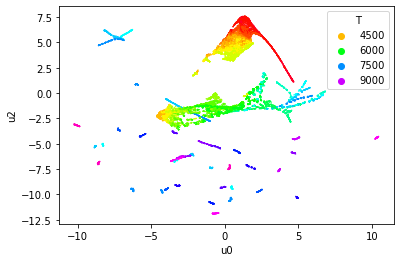

In [262]:
sns.scatterplot(data=dfumap, x="u0", y="u2", marker="o", s=2, edgecolor="none", hue=ds.dfpara["T"], palette="gist_rainbow")

In [ ]:
for i in range(umap_dim):
    df[f"u{i}"] = uu[:,i]

In [157]:
ds.Cs

{'M': array([35,  5, 25,  7, 13,  2, 38, 10, 30,  8, 15, 26, 24,  6,  9, 19, 28,
        16, 22, 17, 37, 32, 14,  3,  4, 11, 18, 27, 12, 31,  1, 39, 29,  0,
        20, 23, 21, 36, 33, 34]),
 'N': array([32, 27, 10, 39,  4, 11,  5, 38, 26,  3,  9,  8, 13, 12,  6, 17, 28,
        35, 15,  7, 14, 19, 36, 18, 16, 22, 34, 25, 24, 23,  1, 30, 31, 20,
         2, 29, 33, 37, 21,  0])}

In [ ]:
ds.get_all_Xrf(top=20, plot=1, X="M")

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(max_depth=16, random_state=0, )

In [ ]:
rf.fit(, lbls)

In [16]:
np.hstack(lbls)

array([0., 0., 0., ..., 4., 4., 4.])

In [ ]:
flux.shape

In [11]:
p.nFlux

{'M': array([[-0.01792928, -0.00735136, -0.00585691, ..., -0.0013398 ,
         -0.00359439, -0.0026757 ],
        [-0.02216401, -0.01128094, -0.00974728, ..., -0.00129216,
         -0.00345479, -0.00254114],
        [-0.03249974, -0.02100932, -0.01949547, ..., -0.00094759,
         -0.00297128, -0.00211783],
        ...,
        [-0.03923602, -0.04686061, -0.05174412, ..., -0.03955266,
         -0.06657242, -0.04452206],
        [-0.0305062 , -0.03429768, -0.04188372, ..., -0.03378448,
         -0.06678738, -0.04612511],
        [-0.02268515, -0.02329823, -0.03281169, ..., -0.02824525,
         -0.066059  , -0.04689079]]),
 'W': array([[-0.00019615, -0.00019156, -0.00025279, ..., -0.00092497,
         -0.00167913, -0.00150203],
        [-0.00019154, -0.00018663, -0.00024746, ..., -0.00090038,
         -0.00174657, -0.0014763 ],
        [-0.00022118, -0.00015025, -0.00021058, ..., -0.00090116,
         -0.00174626, -0.00147616],
        ...,
        [-0.00175696, -0.0043516 , -0.018581

In [43]:
p.prepare_svd()

100%|██████████| 6/6 [00:47<00:00,  7.88s/it]


In [44]:
SPATH = f"/scratch/ceph/swei20/data/dnn/pc/bosz_{p.W[3]}_R{p.W[2]}.h5"

In [45]:
p.save_PCA(SPATH)

In [31]:
p.pcs["M"].shape

(7689, 200)

In [34]:
p.dfpara

,F,T,L,C,O
0,-2.5,3500.0,0.0,-0.50,-0.25
1,-2.5,3500.0,0.0,-0.50,0.00
2,-2.5,3500.0,0.0,-0.50,0.25
3,-2.5,3500.0,0.0,-0.50,0.50
4,-2.5,3500.0,0.0,-0.25,-0.25
...,...,...,...,...,...
51607,-1.0,5500.0,3.5,0.25,0.50
51608,-1.0,5500.0,3.5,0.50,-0.25
51609,-1.0,5500.0,3.5,0.50,0.00
51610,-1.0,5500.0,3.5,0.50,0.25


# Blue Arm

In [6]:
from lv.base.basePCA import PCA

In [7]:
p=PCA()
p.W = p.Ws["Blue"]

In [8]:
PATH = f"/scratch/ceph/szalay/swei20/AE/norm_flux_{p.W[3]}_R{p.W[2]}.h5"

with h5py.File(PATH, 'r') as f:
    flux0 = f['flux'][()]
    wave0 = f['wave'][()]
    para0 = f['para'][()]

In [9]:
p.prepare_data(flux0, wave0, para0)

# M flux: 7689, wave None: (5368,) 
# W flux: 6480, wave None: (5368,) 
# C flux: 3780, wave None: (5368,) 
# B flux: 3300, wave None: (5368,) 
# R flux: 2100, wave None: (5368,) 
# G flux: 9972, wave None: (5368,) 


In [11]:
p.prepare_svd()

100%|██████████| 6/6 [00:45<00:00,  7.52s/it]


In [12]:
SPATH = f"/scratch/ceph/swei20/data/dnn/pc/bosz_{p.W[3]}_R{p.W[2]}.h5"

In [13]:
p.save_PCA(SPATH)